# Multiclass Classification with CNN - `PyTorch Lightning`

In [ ]:
# !pip install -qq torchmetrics torchinfo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as T
from torchmetrics.classification import Accuracy, ConfusionMatrix
from torchinfo import summary

In [ ]:
# !pip install -qq lightning

In [ ]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

In [ ]:
# LightningDataModule
class LiTClassificationDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64, transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        datasets.CIFAR10(root='./data', train=True, download=True)
        datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage):
        self.train_dataset = datasets.CIFAR10(root='./data', train=True, transform=self.transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, transform=self.transform)
        n_val = int(len(test_dataset)*0.2)
        n_test = len(test_dataset) - n_val
        self.test_dataset, self.val_dataset = torch.utils.data.random_split(test_dataset, [n_test, n_val])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.Linear(in_features=4096, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# LightningModule
class LiTCNN(L.LightningModule):
    def __init__(self, num_classes=10, lr=0.0005):
        super().__init__()
        self.save_hyperparameters()

        self.model = CNN(num_classes=num_classes)
        self.example_input_array = torch.ones(2, 3, 32, 32)
        self.model(self.example_input_array) # initialize model
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        self.log("train/loss", loss, on_step=False, on_epoch=True)
        self.train_accuracy(logits, labels)
        self.log("train/accuracy", self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        self.log("val/loss", loss, on_step=False, on_epoch=True)
        self.val_accuracy(logits, labels)
        self.log("val/accuracy", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)
        self.log("test/loss", loss, on_step=False, on_epoch=True)
        self.test_accuracy(logits, labels)
        self.log("test/accuracy", self.test_accuracy, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Data, Model
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.ToPureTensor(),
])
dm = LiTClassificationDataModule(transform=transform)
model_lit = LiTCNN()

# Trainer
checkpoint_callback = ModelCheckpoint(save_top_k=1, mode="max", monitor="val/accuracy")
logger = CSVLogger(save_dir="logs/", name="cnncls")

trainer = L.Trainer(
    max_epochs = 5,
    callbacks = [checkpoint_callback],
    logger = logger,
)

# Training
trainer.fit(model_lit, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode  | In sizes       | Out sizes
-------------------------------------------------------------------------------------------
0 | model          | CNN                | 591 K  | train | [2, 3, 32, 32] | [2, 10]  
1 | criterion      | CrossEntropyLoss   | 0      | train | ?              | ?        
2 | train_accuracy | MulticlassAccuracy | 0      | train | ?              | ?        
3 | val_accuracy   | MulticlassAccurac

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\win-ws\DL-KHU\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\win-ws\DL-KHU\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model_lit, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\win-ws\DL-KHU\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.7336249947547913
        test/loss           0.7738092541694641
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.7738092541694641, 'test/accuracy': 0.7336249947547913}]

In [ ]:
trainer.logger.log_dir

'logs/cnncls\\version_0'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,step,test/accuracy,test/loss,train/accuracy,train/loss,val/accuracy,val/loss
0,0,781,NaN,NaN,NaN,NaN,0.6195,1.044718
1,0,781,NaN,NaN,0.50898,1.376178,NaN,NaN
2,1,1563,NaN,NaN,NaN,NaN,0.6745,0.907372
3,1,1563,NaN,NaN,0.65288,0.991952,NaN,NaN
4,2,2345,NaN,NaN,NaN,NaN,0.7130,0.799837
5,2,2345,NaN,NaN,0.71026,0.834779,NaN,NaN
6,3,3127,NaN,NaN,NaN,NaN,0.7370,0.729936
7,3,3127,NaN,NaN,0.74378,0.739316,NaN,NaN
8,4,3909,NaN,NaN,NaN,NaN,0.7400,0.755451
9,4,3909,NaN,NaN,0.76856,0.663498,NaN,NaN


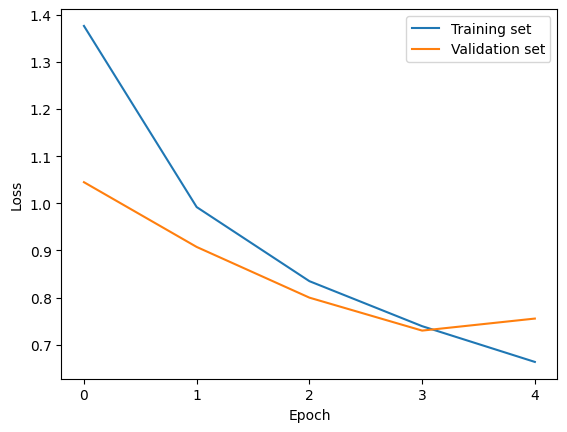

In [ ]:
train_loss = metrics["train/loss"].dropna()
train_epoch = metrics["epoch"][train_loss.index]

val_loss = metrics["val/loss"].dropna()
val_epoch = metrics["epoch"][val_loss.index]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_epoch, train_loss, label="Training set")
ax.plot(val_epoch, val_loss, label="Validation set")
ax.set_xticks(range(5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend();

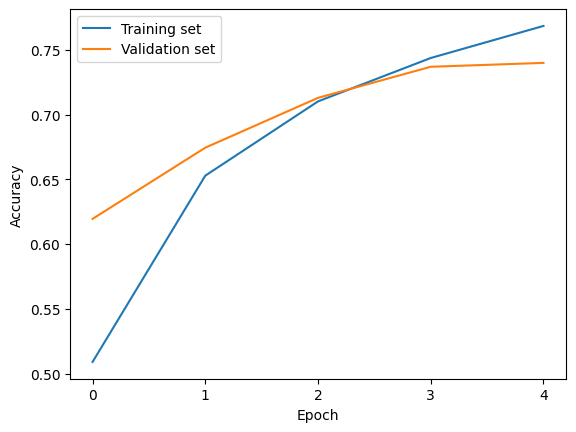

In [ ]:
train_acc = metrics["train/accuracy"].dropna()
train_epoch = metrics["epoch"][train_acc.index]

val_acc = metrics["val/accuracy"].dropna()
val_epoch = metrics["epoch"][val_acc.index]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_epoch, train_acc, label="Training set")
ax.plot(val_epoch, val_acc, label="Validation set")
ax.set_xticks(range(5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend();

In [ ]:
checkpoint_callback.best_model_path

'logs/cnncls\\version_0\\checkpoints\\epoch=4-step=3910.ckpt'

In [ ]:
model_lit = LiTCNN.load_from_checkpoint(checkpoint_callback.best_model_path)
model = model_lit.model

In [ ]:
# Evaluation - Accuracy
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

acc = Accuracy(task="multiclass", num_classes=10)
acc = acc.to(device)

acc_per_cls = Accuracy(task="multiclass", num_classes=10, average=None)
acc_per_cls = acc_per_cls.to(device)

confmat = ConfusionMatrix(task="multiclass", num_classes=10)
confmat = confmat.to(device)

test_loss = 0
test_preds = []
test_labels = []
for batch in tqdm(dm.test_dataloader()):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        logits = model(images)

        preds = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        acc_per_cls.update(preds, labels)
        confmat.update(preds, labels)

        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_acc = acc.compute()
acc.reset()
print("(Test)  accuracy {:.4f}".format(test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

  0%|          | 0/125 [00:00<?, ?it/s]

(Test)  accuracy 0.7336


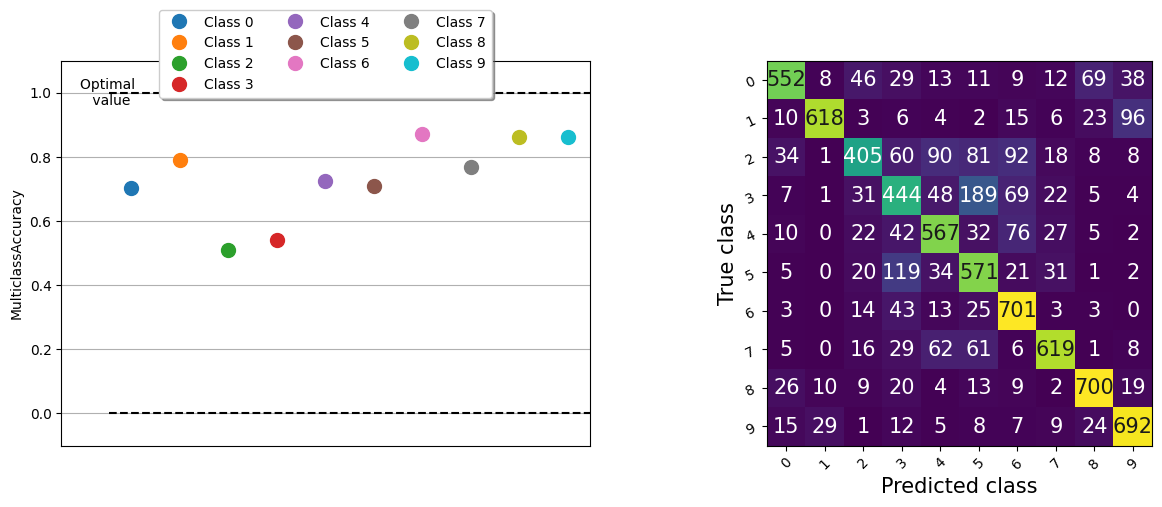

In [ ]:
# Evaluation - Accuracy per class, Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

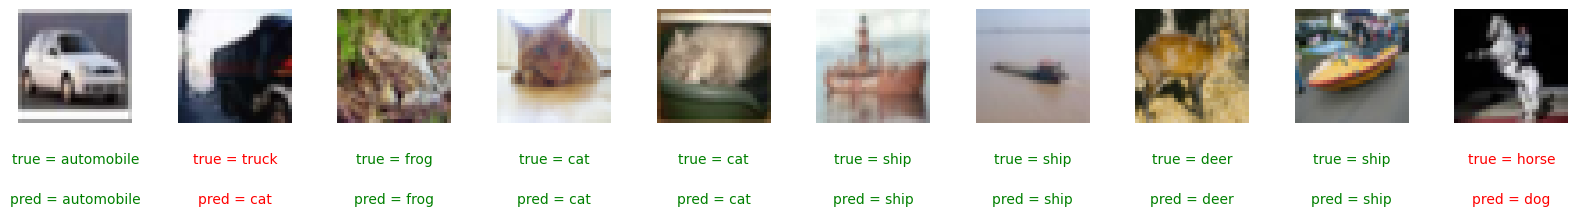

In [ ]:
# Visual evaluation
id2cls = {i: cls for i, cls in enumerate(dm.train_dataset.classes)}

n_to_show = 10
indices = np.random.choice(range(len(dm.test_dataset)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dm.test_dataset[idx][0].permute(1, 2, 0)
    true_label = id2cls[test_labels[idx]]
    pred_label = id2cls[test_preds[idx]]

    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "true = " + true_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "pred = " + pred_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)